In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sys, os
import sklearn
import datetime
import json 

import importlib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import py.st_toolkit as geohl
importlib.reload(geohl)

import cri_calc as cri
importlib.reload(cri)

import cri_helper as helper
importlib.reload(helper)

import nn_evaluation as nne
importlib.reload(nne)

import encounters
importlib.reload(encounters)

<module 'encounters' from '/Users/andrewt/Documents/Univ. Piraeus Research Center/VCRA/encounters.py'>

In [3]:
def get_arrow(angle):
    a = np.deg2rad(angle)
    ar = np.array([[-.25,-.5],[.25,-.5],[0,.5],[-.25,-.5]]).T
    rot = np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]])
    return np.dot(rot,ar).T

# Load Data

In [4]:
SRC_PATH = './data/norway-dataset/oslo_jan_mar_2019_4w_prep_algn_linear_v2_w_lens.csv'

df = pd.read_csv(SRC_PATH, parse_dates=['datetime'])
gdf = gpd.GeoDataFrame(
    df, 
    crs=4326,
    geometry=gpd.points_from_xy(df['lon'], df['lat'])
)

In [5]:
# NORWAY ONLY
gdf.rename({'sog':'speed',
            'cog':'course',
            'lengde':'length'}, axis=1, inplace=True)

gdf = gdf.loc[gdf.speed < 50].copy()

# Create Training Dataset

In [6]:
from sklearn.neighbors import KDTree, BallTree
import itertools
from tqdm import tqdm
import contextily as ctx

from joblib import Parallel, delayed
import multiprocessing

In [7]:
def applyParallel(df_grouped, fun, n_jobs=-1, **kwargs):
    '''
    Forked from: https://stackoverflow.com/a/27027632
    '''
    n_jobs = multiprocessing.cpu_count() if n_jobs == -1 else n_jobs
    print(f'Scaling {fun} to {n_jobs} CPUs')

    df_grouped_names = df_grouped.grouper.names
    _fun = lambda name, group: (fun(group.drop(df_grouped_names, axis=1)), name)

    result, keys = zip(*Parallel(n_jobs=n_jobs)(
        delayed(_fun)(name, group) for name, group in tqdm(df_grouped, **kwargs)
    ))
    return pd.concat(result, keys=keys, names=df_grouped_names)

In [8]:
def homogenize_units(vcra_data):
    # Unit Conversions (for the sake of homogeneity)

    ## Convert COURSE from DEGREES to RADIANS
    vcra_data.insert(
        vcra_data.columns.get_loc('own_course') + 1, 
        'own_course_rad', 
        vcra_data.own_course.apply(helper.degrees_to_radians)
    )

    vcra_data.insert(
        vcra_data.columns.get_loc('target_course') + 1, 
        'target_course_rad', 
        vcra_data.target_course.apply(helper.degrees_to_radians)
    )


    ## Convert LENGTH from METERS to NAUTICAL MILES
    vcra_data.insert(
        vcra_data.columns.get_loc('own_length') + 1, 
        'own_length_nmi', 
        vcra_data.own_length / 1852
    )

    vcra_data.insert(
        vcra_data.columns.get_loc('target_length') + 1, 
        'target_length_nmi', 
        vcra_data.target_length / 1852
    )
    
    return vcra_data

## Discover vessels in an Encountering Process

In [14]:
encountering_pairs, results = encounters.encountering_vessels(gdf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41163/41163 [08:47<00:00, 78.07it/s]


Text(0.5, 1.0, 'CRI Density Plot (OLD)')

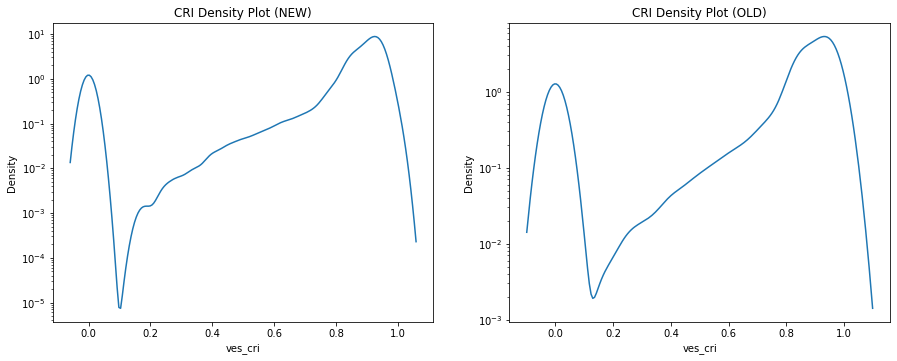

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15, 5.5))

sns.kdeplot(data=results, x="ves_cri", ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('CRI Density Plot (NEW)')

sns.kdeplot(data=pd.read_pickle(f'./data/norway-dataset/oslo_jan_mar_2019_4w_prep_encountering.vcra_dataset_v12.pickle'), x="ves_cri", ax=ax[1])

ax[1].set_yscale('log')
ax[1].set_title('CRI Density Plot (OLD)')

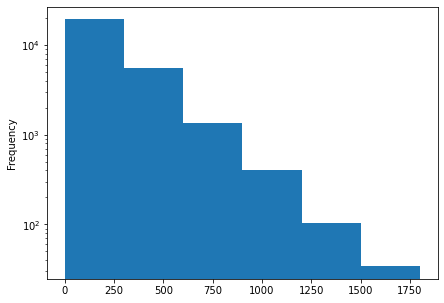

In [16]:
temp = (encountering_pairs.end - encountering_pairs.start).astype('timedelta64[s]')

fig, ax = plt.subplots(1,1, figsize=(7,5))
temp.plot.hist(bins=np.arange(0, max(temp), 300), ax=ax)

ax.set_yscale('log')

In [17]:
temp.loc[temp >= 300].describe()

count    7345.000000
mean      505.090538
std       226.835999
min       300.000000
25%       360.000000
50%       420.000000
75%       600.000000
max      1980.000000
dtype: float64

In [18]:
DEST_PATH_PREFIX = './data/norway-dataset/oslo_jan_mar_2019_4w_prep'

encountering_pairs.to_pickle(f'{DEST_PATH_PREFIX}_encountering.pairs_v14.pickle')
homogenize_units(results.copy()).to_pickle(f'{DEST_PATH_PREFIX}_encountering.vcra_dataset_v14.pickle')